# **4-2. YOLOv3 실습**

## 학습목표

YOLOv3을 구현해 봅니다.

**목차(context)**
- 필요한 파일 및 package 다운로드
- Postprocessing
- Pre-trained model 불러오기
- Inference, Visualization


> 이번 실습에서는 YOLOv3 알고리즘을 직접 구현해 보는 실습을 진행해 보겠습니다. YOLOv3 알고리즘은 기존 YOLO 알고리즘을 개선한 연구로 단 하나의 anchor box만 할당하는 방법, Prediction 시 grid의 상대적 위치로 bounding box의 위치를 찾아내는 아이디어 등 여러 측면이 보완된 알고리즘입니다.


> Yolo v1. 빠른 속도, 낮은 정확도\
> Yolo v2. v1 대비 속도, 성능 개선\
> Yolo v3. v2 대비 속도 저하, 성능 개선 (small object 성능 개선)\
> Yolo v4. v3 대비 속도, 성능 개선

<img src = "https://blog.kakaocdn.net/dn/sc5vS/btqXxe7GzI2/oL8SH2SltUVYPKZHj217QK/img.png" height = 300 width = 400>


> bbox를 직접 예측하지 않고, 기존에 설정된 anchor box에 대해 $t_x$, $t_y$, $t_w$, $t_h$ 를 예측하며 offset 값 조절.\
> $c_{x,y}$ 중심 좌표를 예측\
> $b_{x,y}$ = sigmoid($t_{x,y}$) + $c_{x,y}$

> YOLOv3는 anchor box를 이용해 객체 탐지를 수행한다. YOLOv3는 기존 YOLO에서 사용된 방식인 모든 구역을 일정 크기의 cell로 분리한다는 개념을 차용하여 cell을 anchor box로 사용하였고 그림으로 표현하면 위와 같다.

> YOLOv3 네트워크는 각 Bounding Box (tx, ty, tw, th)에 대해 4개의 좌표를 예측한다. 셀이 이미지의 왼쪽 상단 모서리에서 (cx, cy)만큼 offset되고, 이전 Bounding Box의 너비와 높이가 pw, ph인 경우 YOLO의 아이디어에 따라 bx, by, bw, bh의 prediction (즉, anchor box와 실체 객체가 가지는 bbox와의 차이(offset)에 해당하는 값) 을 얻을 수 있다.

<!-- ![yolov3](https://drive.google.com/uc?export=view&id=1i8R2Ot1xnsc0S1AJHiQT_o8MSTKSzAkA) -->

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbgZ77Q%2FbtqXgoYyV3h%2FOKkkN33ui42vuF4XkLAkz0%2Fimg.png" height = 300 width = 400>

<img src = "https://drive.google.com/uc?export=view&id=1i8R2Ot1xnsc0S1AJHiQT_o8MSTKSzAkA" height = 600 width = 900>

<!-- ![bbox](https://blog.kakaocdn.net/dn/sc5vS/btqXxe7GzI2/oL8SH2SltUVYPKZHj217QK/img.png) -->



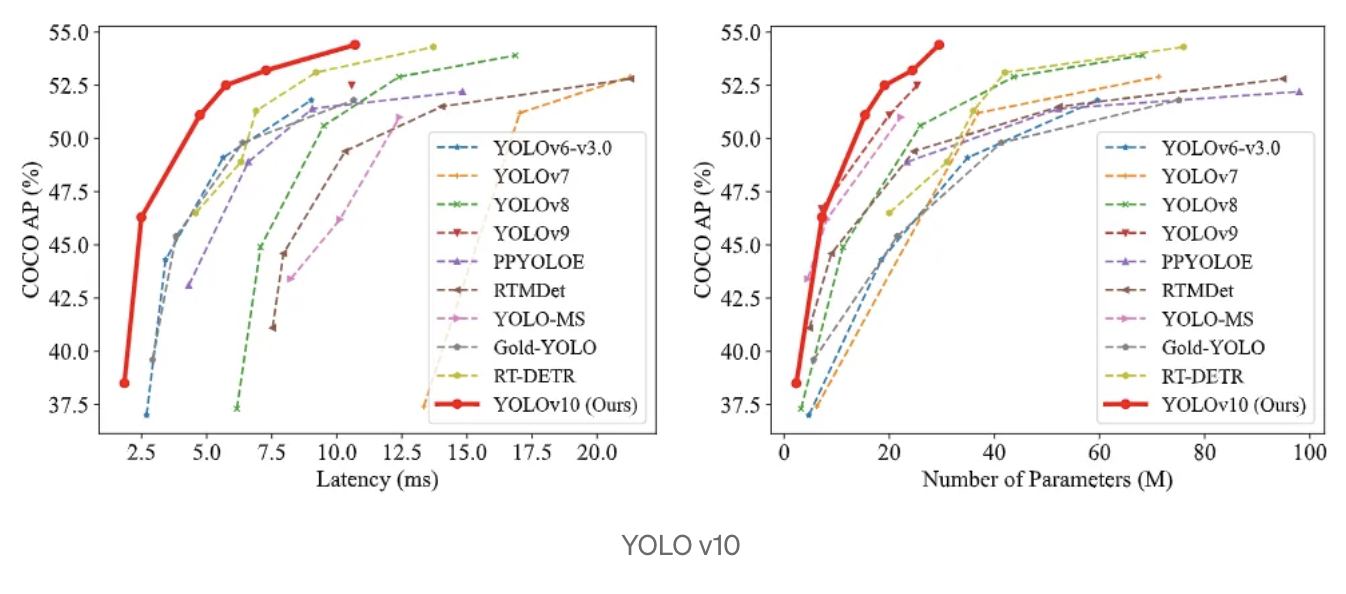

> YOLOv3는 anchor box를 이용해 객체 탐지를 수행한다. YOLOv3는 기존 YOLO에서 사용된 방식인 모든 구역을 일정 크기의 cell로 분리한다는 개념을 차용하여 cell을 anchor box로 사용하였고 그림으로 표현하면 위와 같다.

> YOLOv3 네트워크는 각 Bounding Box (tx, ty, tw, th)에 대해 4개의 좌표를 예측한다. 셀이 이미지의 왼쪽 상단 모서리에서 (cx, cy)만큼 offset되고, 이전 Bounding Box의 너비와 높이가 pw, ph인 경우 YOLO의 아이디어에 따라 bx, by, bw, bh의 prediction (즉, anchor box와 실체 객체가 가지는 bbox와의 차이(offset)에 해당하는 값) 을 얻을 수 있다.


## 1. Download & Import Packages

> 먼저, 필요한 파일을 다운받고, package를 설치하고, 아래 코드를 사용하여 import 합니다.

In [ ]:
!wget https://www.dropbox.com/scl/fi/oco115vwgatdded392ito/yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs&st=y0oj40tu&dl=0
!unzip yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs
!mv ./yolov3/* ./

--2024-07-02 13:40:37--  https://www.dropbox.com/scl/fi/oco115vwgatdded392ito/yolov3.zip?rlkey=vks97kzdnt9sd9o42uszlv8vs
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1cc0920bec95afca9f73da91e9.dl.dropboxusercontent.com/cd/0/inline/CV8ohFP-QExa2ESBawjKvtdwZ9o4DmFNeKAPIDtQ6giDDC0Nm3FasOz3crMQVfT6GS9sO_gzLKAYaSBf8AhToIAkZMEiwOsgZyMj_2Kveq5wfW8zLKk8t1FdzZ7tuAOpqZbkuD5_O0MswF2fCfZWJQiV/file# [following]
--2024-07-02 13:40:38--  https://uc1cc0920bec95afca9f73da91e9.dl.dropboxusercontent.com/cd/0/inline/CV8ohFP-QExa2ESBawjKvtdwZ9o4DmFNeKAPIDtQ6giDDC0Nm3FasOz3crMQVfT6GS9sO_gzLKAYaSBf8AhToIAkZMEiwOsgZyMj_2Kveq5wfW8zLKk8t1FdzZ7tuAOpqZbkuD5_O0MswF2fCfZWJQiV/file
Resolving uc1cc0920bec95afca9f73da91e9.dl.dropboxusercontent.com (uc1cc0920bec95afca9f73da91e9.dl.dropboxusercontent.com)... 162.125.81.15, 2620

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2024-07-02 13:51:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  12.2MB/s    in 19s     

2024-07-02 13:52:03 (12.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-07-02 13:52:03--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  13.5MB/s    in 22s     

2024-07-02 13:52:26 (7.20 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
! mkdir /content/weights
! mv /content/yolov3.weights /content/weights/yolov3.weights
! mv /content/darknet53.conv.74 /content/weights/darknet53.conv.74

mv: cannot stat '/content/yolov3.weights': No such file or directory
mv: cannot stat '/content/darknet53.conv.74': No such file or directory


In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 646.5 kB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

In [ ]:
import argparse
import yaml
import os

import cv2
import numpy as np
import torch
from torch.autograd import Variable
import torchvision

from models.yolov3 import *
from utils.utils import get_coco_label_names, preprocess, yolobox2label
from utils.parse_yolo_weights import parse_yolo_weights

from utils.vis_bbox import vis_bbox
import matplotlib.pyplot as plt

## 2. IoU, NMS

> 이전 챕터에서 배웠던 IoU 알고리즘과 NMS 알고리즘을 구현합니다.

In [ ]:
def iou(box1, box2):
    """
        Calculate the Intersection of Unions (IoUs) between bounding boxes.

        Input:
            box1 : Bounding Box1의 좌표값, np.array 형태의 [x1, y1, x2, y2]
            box2 : Bounding Box2의 좌표값, np.array 형태의 [x1, y1, x2, y2]
    """
    # 직사각형 box1, box2 의 넓이를 구한다.
    b1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    b2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # 겹치는 box의 x좌표, y좌표의 최소 최대값을 구한다.
    x_i_min = max(box1[0], box2[0])
    x_i_max = min(box1[2], box2[2])
    y_i_min = max(box1[1], box2[1])
    y_i_max = min(box1[3], box2[3])

    # 위 그림에 설명된 원리에 따라, 교집합 영역의 좌표를 구한다.
    w = max(0, x_i_max - x_i_min)
    h = max(0, y_i_max - y_i_min)
    intersection = w * h
    iou = intersection / (b1_area + b2_area - intersection)

    return iou

In [ ]:
def nms(bbox, thresh, score=None):
    """
        Input:
            bbox : Bounding Box들의 좌표값, np.array 형태 (e.g., [[x1, y1, x2, y2], [x1, y1, x2, y2], [x1, y1, x2, y2]])
                   array([[199.66446, 243.73654, 234.61401, 272.00906],
                          [199.67168, 244.4378 , 231.70439, 271.90186],
                          [202.07721, 242.86081, 233.41031, 267.57233]]
            thresh : IoU의 Threshold 값
            score : 각 Bounding Box의 Confidence Score 값
    """

    # Bounding Box가 비어있는지 확인
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    # Score가 큰 순서대로 정렬
    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = np.prod(bbox[:, 2:] - bbox[:, :2], axis=1)


    # 최종 선택된 Bounding Box를 표시하는 output (e.g., selec = [True, False, True])
    # True : 남아있는 Bounding Box / False : 남아있지 않은 Bounding Box
    selec = np.zeros(bbox.shape[0], dtype=bool)
    # [False, False, False]

    # Bounding Box 끼리의 IoU를 계산하고, IoU가 threshold 이상인 output은 False로 변경
    for i, b in enumerate(bbox):
        # b = [x1, y1, x2, y2]
        bl = np.maximum(b[:2], bbox[selec, :2])
        tr = np.minimum(b[2:], bbox[selec, 2:])
        area = np.prod(tr - bl, axis=1) * (bl < tr).all(axis=1)

        iou = area / (bbox_area[i] + bbox_area[selec] - area)

        # IoU가 threshold 이상인 output은 False로 / threshold 미만인 output은 True로 설정
        if (iou < thresh).all():
          selec[i] = True

    selec = np.where(selec)[0]

    if score is not None:
        selec = order[selec]

    return selec.astype(np.int32)

## 3. Load pre-trained YOLO-v3

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--cfg', type=str, default='config/yolov3_default.cfg')
parser.add_argument('--ckpt', type=str, help='path to the checkpoint file')
parser.add_argument('--weights_path', type=str, default='/content/weights/yolov3.weights', help='path to weights file')
parser.add_argument('--image', default='data/innsbruck.png', type=str)
parser.add_argument('--detect_thresh', type=float, default=0.5, help='confidence threshold')

args = parser.parse_args(args=[])

In [ ]:
!pip install pyyaml==5.4.1

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
with open(args.cfg, 'r') as f:
    cfg = yaml.safe_load(f)

imgsize = cfg['TEST']['IMGSIZE']
model = YOLOv3(cfg['MODEL'])

confthre = cfg['TEST']['CONFTHRE']
nmsthre = cfg['TEST']['NMSTHRE']

if args.detect_thresh:
    confthre = args.detect_thresh

> Pretrain된 YOLO-v3 의 weight를 불러옵니다.

In [ ]:
assert args.weights_path or args.ckpt, 'One of --weights_path and --ckpt must be specified'

if args.weights_path: # YOLO 알고리즘에 사용될 weight가 있는 경우
    print("loading yolo weights %s" % (args.weights_path))
    parse_yolo_weights(model, args.weights_path)
elif args.ckpt: # YOLO 알고리즘에 사용될 checkpoint가 있는 경우
    print("loading checkpoint %s" % (args.ckpt))
    state = torch.load(args.ckpt)
    if 'model_state_dict' in state.keys(): # model_state_dict가 ckpt에 있는 경우
        model.load_state_dict(state['model_state_dict'])
    else:
        model.load_state_dict(state)

loading yolo weights /content/weights/yolov3.weights


In [ ]:
model

YOLOv3(
  (module_list): ModuleList(
    (0): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): resblock(
      (module_list): ModuleList(
        (0): ModuleList(
          (0): Sequential(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): Sequential(
            (conv): Conv2d(32, 64, kernel_size=(3, 3),

> 예시 이미지 1장을 불러옵니다.

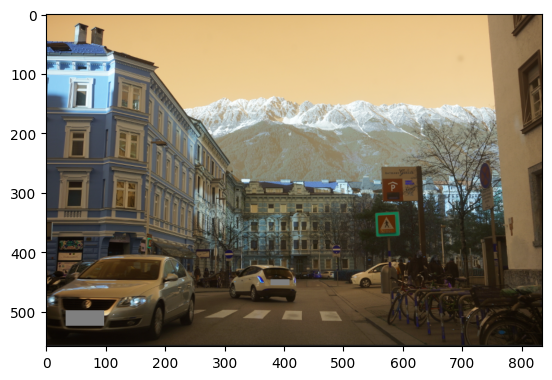

In [ ]:
img = cv2.imread(args.image)
plt.imshow(img)

In [ ]:
'''
preprocess 반환:
이미지: (C, H, W) 의 shape으로 이미지 반환
이미지의 정보: (H, W, NH, NW, DX, DY) 로 이루어진 튜플
H, W: 이미지의 원래 shape
NH, NW: padding을 포함하지 않은 resized된 image 정보
DX, DY: padding의 크기
'''

img_raw = img.copy()[:, :, ::-1].transpose((2, 0, 1)) # [:, :, ::-1]: OpenCV로 불러온 이미지를 numpy에서 사용 시 변환하는 과정
img, info_img = preprocess(img, imgsize, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)

if args.gpu >= 0:
    model.cuda(args.gpu)
    img = img.type(torch.cuda.FloatTensor)
else:
    img = img.type(torch.FloatTensor)

In [ ]:
print(f'Befor preprocessing --   Image size: {img_raw.shape},   Min value: {img_raw.min()},   Max value: {img_raw.max()}')
print(f'After preprocessing --   Image size: {img.shape},   Min value: {img.min()},   Max value: {img.max()}')

Befor preprocessing --   Image size: (3, 559, 835),   Min value: 0,   Max value: 255
After preprocessing --   Image size: torch.Size([1, 3, 416, 416]),   Min value: 0.003921568859368563,   Max value: 1.0


## 4. Inference and Visualization, Postprocess 함수 제작

> 각 box의 대각 모서리 쌍의 좌표를 사용하여 두 box의 IoU를 계산하는 것이 더 쉬우므로, 중심 점을 좌측 상단, 우측 하단 모서리 좌표로 변환하는 코드를 구현하여 전처리를 준비한다. 이후, YOLO 모델의 output을 prediction한다.

10,647?
- 13x13 그리드: 13 x 13 x 3 = 507 boxes
- 26x26 그리드: 26 x 26 x 3 = 2,028 boxes
- 52x52 그리드: 52 x 52 x 3 = 8,112 boxes
- 총합: 507 + 2,028 + 8,112 = 10,647 boxes

85?
- 처음 4개 값: bounding box의 좌표 (x, y, width, height)
- 다음 1개 값: confidence score (객체가 존재할 확률)
- 나머지 80개 값: 클래스 확률 (COCO 데이터셋 기준 80개 클래스)



즉, 각 10,647개의 예측에 대해:
1. confidence score를 확인
2. 높은 confidence score를 가진 박스에 대해, 클래스 확률을 확인.
3. 특정 임계값 이상의 확률을 가진 클래스를 해당 박스의 예측 클래스로 간주.
4. NMS을 적용하여 중복된 검출을 제거.





In [ ]:
model.eval()
# img = img.contiguous()
with torch.no_grad():
    outputs = model(img)

prediction = outputs
prediction.shape

/content/models/yolo_layer.py:83: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  x_shift = dtype(np.broadcast_to(
/content/models/yolo_layer.py:83: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x_shift = dtype(np.broadcast_to(


torch.Size([1, 10647, 85])

In [ ]:
# postprocess 함수의 일부: box_corner를 바탕으로 prediction

model.eval()

with torch.no_grad():
    outputs = model(img)

prediction = outputs

num_classes = 80
conf_thre = 0.3
nms_thre = 0.3
# YOLO는 기본적으로 (x_center, y_center, width, height) 형식으로 바운딩 박스를 예측하기 때문에,
# 이를 (x1, y1, x2, y2) 형식으로 변환, x1, y1: 박스의 좌상단 좌표, x2, y2: 박스의 우하단 좌표

# new: 같은 데이터 타입(예: float32), shape, device를 갖는 새 텐서 생성.
box_corner = prediction.new(prediction.shape)
############################################
# 아래를 활용해 일반적인 bbox 좌표를 생성하시오: (x_center, y_center, width, height) -> (x1, y1, x2, y2)

box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
############################################
prediction[:, :, :4] = box_corner[:, :, :4]

print(prediction)
print(prediction.shape)

tensor([[[-2.5990e+01, -3.6794e+01,  6.4139e+01,  ...,  2.2666e-05,
           6.9252e-05,  4.7439e-05],
         [-2.5409e+01, -8.5867e+00,  1.4278e+02,  ...,  2.6045e-05,
           2.8728e-05,  3.1191e-05],
         [-2.5824e+01, -3.7769e+00,  1.7511e+02,  ...,  1.4327e-05,
           5.9894e-05,  3.6360e-05],
         ...,
         [ 3.6607e+02,  4.0754e+02,  4.2554e+02,  ...,  1.1301e-05,
           8.1663e-06,  4.7895e-06],
         [ 3.8451e+02,  4.0489e+02,  4.2022e+02,  ...,  5.7533e-05,
           4.8281e-05,  3.5860e-05],
         [ 3.8107e+02,  4.0817e+02,  4.4107e+02,  ...,  3.0465e-04,
           3.9794e-04,  4.3749e-04]]], device='cuda:0')
torch.Size([1, 10647, 85])


In [ ]:
output = [None for _ in range(len(prediction))]
for i, image_pred in enumerate(prediction):
    # Threshold에 의해 confidence scores를 필터링함.
    ############################################
    # 각 image_pred는 [10647, 85]의 shape을 갖는다.
    # 그 중, 85는 (x, y, width, height, confidence score, class_probs1, ..., class_probsN) 의미를 갖는다.

    # 1. 바운딩 박스에 클래스 할당을 위해 가장 높은 클래스 한개만 부여하는 class_pred를 만들어보자.
    # hint: torch.max(..., 1)이용. 각 바운딩 박스에 대해 가장 높은 클래스 확률
    class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1)
    class_pred = class_pred[0]

    # 2. (confidence score (image_pred의 4번째 요소) * class prediction) 이 일정이상의 threshold를 넘는 것만 추출하는 boolen

    conf_mask = (image_pred[:, 4] * class_pred >= conf_thre).squeeze()


    # 만일 클래스별 확률이 아래와 같다면
    # [[0.1, 0.3, 0.2],
    # [0.5, 0.1, 0.4],
    # [0.2, 0.6, 0.1]]
    # torch.max는 (tensor([0.3, 0.5, 0.6]), tensor([1, 0, 1]))를 반환.

    print(conf_mask.shape)
    ############################################
    image_pred = image_pred[conf_mask]
    # 만약에 단 한개도 남지 않았다면 => 다음 이미지 처리
    if not image_pred.size(0):
        continue

    # threshold와 비교하여 높은 confidence score를 통하여 detection 수행
    ############################################
    # 3. 모든 bbox가 여러개 클래스일 수 있는 상황 고려
    # Hint: [바운딩 박스 인덱스, 클래스 인덱스] = (모든 클래스 확률 x bbox confidence score 계산 후, threshold 넘는가).nonzero()

    ind = (image_pred[:, 5:] * image_pred[:, 4][:, None] >= conf_thre).nonzero()
    # ind는 최종 [[0, 2], [1, 5],[1, 7]]와 같다면, 그 의미는
    # 0번째 바운딩 박스가 2번 클래스에 대해 높은 신뢰도를 갖고, 1번째 바운딩 박스가 5번과 7번 클래스 모두에 대해 높은 신뢰도를 갖음.
    ############################################

    # Detection은 다음과 같이 정렬됨: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
    # bounding box 하나가 사실은 80개 class에 대해 각각 존재한다고 생각할 수 있음.

    detections = torch.cat((
            image_pred[ind[:, 0], :5],                         # x1,y1,x2,y2, confidence score 까지. (# shape: [M, 5])
            image_pred[ind[:, 0], 5 + ind[:, 1]].unsqueeze(1), #ind 계산시 확률 인덱스 + 5자리 이후부터가 실제 확률값, concat 위해 unsqueeze (# shape: [M, 1])
            ind[:, 1].float().unsqueeze(1)                     # (# shape: [M, 1])
    ), 1)

    # ==> 만약 10,647개의 초기 바운딩 박스 중 50개만 임계값을 넘었다면, detections의 shape은 [50, 7]
    #     극단적으로 모든 바운딩 박스가 모든 클래스에 대해 임계값을 넘으면 shape이 [10647 * num_classes, 7]까지 커질 수 있지만, 실제로는 매우 드문일.


    # Class-wise NMS 계산.
    # 예측된 모든 class에 대하여 반복
    unique_labels = detections[:, -1].cpu().unique()
    if prediction.is_cuda:
        unique_labels = unique_labels.cuda()

    # 같은 class 끼리 nms
    for c in unique_labels:
        # 해당 class에 대해 detection 수행
        detections_class = detections[detections[:, -1] == c]
        nms_in = detections_class.cpu().numpy()
        nms_out_index = nms(nms_in[:, :4], nms_thre, score=nms_in[:, 4] * nms_in[:, 5])
        detections_class = detections_class[nms_out_index]
        if output[i] is None:
            output[i] = detections_class
        else:
            output[i] = torch.cat((output[i], detections_class))
print(output)

[tensor([[3.3222e+02, 2.7280e+02, 3.4653e+02, 2.9699e+02, 6.8351e-01, 9.9843e-01,
         0.0000e+00],
        [3.0638e+02, 2.6938e+02, 3.2042e+02, 2.9680e+02, 6.7000e-01, 9.9839e-01,
         0.0000e+00],
        [3.1837e+02, 2.7171e+02, 3.3287e+02, 2.9560e+02, 6.2890e-01, 9.9660e-01,
         0.0000e+00],
        [2.9647e+02, 2.7299e+02, 3.0458e+02, 2.9120e+02, 4.6995e-01, 9.8935e-01,
         0.0000e+00],
        [1.4336e+02, 2.8359e+02, 1.5034e+02, 2.9892e+02, 3.9992e-01, 9.1465e-01,
         0.0000e+00],
        [3.6105e+02, 3.0342e+02, 4.1641e+02, 3.4598e+02, 8.0982e-01, 9.8775e-01,
         1.0000e+00],
        [2.8734e+02, 2.9068e+02, 3.1470e+02, 3.3219e+02, 6.2338e-01, 9.8815e-01,
         1.0000e+00],
        [3.1536e+02, 2.9390e+02, 3.6635e+02, 3.3317e+02, 3.8088e-01, 9.9115e-01,
         1.0000e+00],
        [1.5337e+02, 2.7818e+02, 2.1187e+02, 3.1041e+02, 9.9725e-01, 9.8573e-01,
         2.0000e+00],
        [6.9099e-01, 2.7158e+02, 1.3320e+02, 3.4025e+02, 9.9963e-01, 9.8

In [ ]:
tensor = torch.tensor([[0.1, 0.3, 0.2],
                       [0.5, 0.1, 0.4],
                       [0.2, 0.6, 0.1]])
max_values, max_indices = torch.max(tensor, dim=0)
max_values, max_indices

> 위에서 배운 내용을 토대로 전체 함수를 구현한 결과는 다음과 같습니다.

In [ ]:
def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.1):
    """
    YOLO 모델의 output을 postprocessing하는 함수
    box transformation, class-wise non-maximum suppression을 수행함.
    입력:
        prediction (torch tensor): :math:`(N, B, 4)` 와 같은 shape으로 주어짐.
            :math:`N` 은 prediction의 개수,
            :math:`B` 는 box의 개수를 의미함.
            :math:`xc, yc, w, h` 에서, `xc` 와 `yc` 는 bounding box의 center를 의미함.
        num_classes (int):
            dataset class의 개수
        conf_thre (float):
            0부터 1 까지의 confidence threshold 값으로 config file에 정의되어 있다.
        nms_thre (float):
            non-max suppression을 위한 IoU threshold로 0부터 1까지 값이 주어진다.
    """

    """
      prediction : [1, 10647, 85]
      10647 = 507 (= 13x13x3) + 2028 (= 26x26x3) + 8112 (= 52x52x3)
      85 = 4 (xc, yc, w, h) + 1 (objectnee = confidence score) + 80 (# of class)
    """
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):
        # Threshold에 의해 confidence scores를 필터링함.
        class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1)
        class_pred = class_pred[0]
        conf_mask = (image_pred[:, 4] * class_pred >= conf_thre).squeeze()
        image_pred = image_pred[conf_mask]

        # 만약에 단 한개도 남지 않았다면 => 다음 이미지 처리
        if not image_pred.size(0):
            continue
        # threshold와 비교하여 높은 confidence score를 통하여 detection 수행
        ind = (image_pred[:, 5:] * image_pred[:, 4][:, None] >= conf_thre).nonzero()
        # Detection은 다음과 같이 정렬됨: (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((
                image_pred[ind[:, 0], :5],
                image_pred[ind[:, 0], 5 + ind[:, 1]].unsqueeze(1),
                ind[:, 1].float().unsqueeze(1)
                ), 1)
        # 예측된 모든 class에 대하여 반복
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()

        # 같은 class 끼리 nms
        for c in unique_labels:
            # 해당 class에 대해 detection 수행
            detections_class = detections[detections[:, -1] == c]
            nms_in = detections_class.cpu().numpy()
            nms_out_index = nms(nms_in[:, :4], nms_thre, score=nms_in[:, 4] * nms_in[:, 5])
            detections_class = detections_class[nms_out_index]
            if output[i] is None:
                output[i] = detections_class
            else:
                output[i] = torch.cat((output[i], detections_class))

    return output

### 5. Postprocessing 함수 사용

In [ ]:
model.eval()

with torch.no_grad():
    outputs = model(img)
    outputs_post = postprocess(outputs, 80, conf_thre=0.3, nms_thre=0.9) # nms 0.9로 아주 관대하게 설정. 90% 겹쳐도 다른 사물로 인식.

if outputs_post[0] is None:
    print("No Objects Deteted!!")
    assert AssertionError

coco_class_names, coco_class_ids, coco_class_colors = get_coco_label_names()
print(len(outputs), len(outputs_post), len(outputs_post[0][0]), len(outputs_post[0]))

> 데이터 시각화를 위하여, COCO에서 등장하는 label들을 불러옵시다. `coco_class_names` 는 person, car 등 물체의 이름을 의미합니다. 각 번호(`coco_class_ids`) 는 predict한 물체를 식별하는 데 사용되며, 색상(`coco_class_colors`)은 식별한 객체를 시각화하는데 사용됩니다.

> 다음은 car의 예시입니다.

In [ ]:
print(coco_class_names[3])
print(coco_class_ids[3])
print(coco_class_colors[3])

car
4
[164 253 144]


> `yolobox2label` 함수는 YOLO box label을 YXYX box label로 변경하는 함수입니다. 해당 함수를 활용하기 위하여 center 값을 YXYX 형태로 변환합니다.


In [ ]:
bboxes = list()
classes = list()
colors = list()

for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs_post[0]:
    cls_id = coco_class_ids[int(cls_pred)]
    print(int(x1), int(y1), int(x2), int(y2), float(conf), int(cls_pred))
    print('\t+ Label: %s, Conf: %.5f' % (coco_class_names[cls_id], cls_conf.item()))
    box = yolobox2label([int(y1), int(x1), int(y2), int(x2)], info_img)
    bboxes.append(box)
    classes.append(cls_id)
    colors.append(coco_class_colors[int(cls_pred)])

332 272 346 296 0.6835078597068787 0
	+ Label: person, Conf: 0.99843
306 269 320 296 0.6699966788291931 0
	+ Label: person, Conf: 0.99839
318 271 332 295 0.6288965940475464 0
	+ Label: person, Conf: 0.99660
361 303 416 345 0.809822678565979 1
	+ Label: bicycle, Conf: 0.98775
287 290 314 332 0.6233804821968079 1
	+ Label: bicycle, Conf: 0.98815
153 278 211 310 0.9972495436668396 2
	+ Label: car, Conf: 0.98573
0 271 133 340 0.9996312856674194 2
	+ Label: car, Conf: 0.98206
257 277 295 300 0.9624319672584534 2
	+ Label: car, Conf: 0.95359


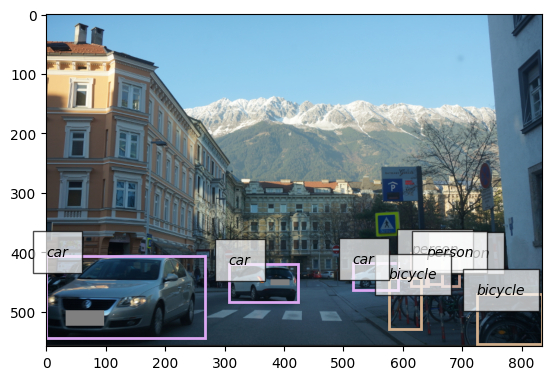

In [ ]:
vis_bbox(img_raw, bboxes, label=classes, label_names=coco_class_names, instance_colors=colors, linewidth=2)
plt.show()

# NMS threshold와 confidence threshold 를 조절
---



In [ ]:
model.eval()

with torch.no_grad():
    outputs = model(img)
    outputs_post = postprocess(outputs, 80, conf_thre=0.7, nms_thre=0.45) # nms 0.9로 아주 관대하게 설정. 90% 겹쳐도 다른 사물로 인식.

bboxes = list()
classes = list()
colors = list()

for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs_post[0]:
    cls_id = coco_class_ids[int(cls_pred)]
    print(int(x1), int(y1), int(x2), int(y2), float(conf), int(cls_pred))
    print('\t+ Label: %s, Conf: %.5f' % (coco_class_names[cls_id], cls_conf.item()))
    box = yolobox2label([int(y1), int(x1), int(y2), int(x2)], info_img)
    bboxes.append(box)
    classes.append(cls_id)
    colors.append(coco_class_colors[int(cls_pred)])

In [ ]:
vis_bbox(img_raw, bboxes, label=classes, label_names=coco_class_names, instance_colors=colors, linewidth=1)
plt.show()